<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [592]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [593]:
# Load the data
df = pd.read_csv('./housing.csv')
house = df

# Data Cleaning & Feature Engineering

In [594]:
# A:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [595]:
# Drop ID column first
house.drop(labels='Id', axis=1, inplace=True)

In [596]:
# MSSubClass should be categorical
house['MSSubClass'] = house['MSSubClass'].astype('category')

In [597]:
# drop all non residential houses
house.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [598]:
house.drop(house[house['MSZoning'] == 'C (all)'].index, inplace=True)

In [599]:
# Get all index for test / train set size
# 
test_set_index = house[house['YrSold'] >= 2010].index
train_set_index = house[house['YrSold'] < 2010].index
print(test_set_index)
print(train_set_index)

Int64Index([  16,   24,   26,   27,   33,   38,   45,   52,   63,   66,
            ...
            1396, 1408, 1416, 1421, 1428, 1438, 1446, 1456, 1457, 1458],
           dtype='int64', length=172)
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1459],
           dtype='int64', length=1278)


In [600]:
# LotFrontage, replace nan with median, mean close to median
house.LotFrontage.fillna(house.LotFrontage.median(), inplace=True)
house.LotFrontage.isnull().sum()

0

In [601]:
# Alley, get dummy then replace nan with 0
# Reference to No Alley
alley = house[['Alley']].fillna('No Alley')
alley_dummy = pd.get_dummies(alley, prefix='Alley')
alley_dummy.drop(labels='Alley_No Alley', axis=1, inplace=True)
house = pd.concat([house, alley_dummy], axis=1)

In [602]:
# Engineer year columns, built / remodel in 21st century or not
house['Built_21stC'] = house['YearBuilt'].map(lambda x: 1 if x >= 2000 else 0)
house['RemodAdd_21stC'] = house['YearRemodAdd'].map(lambda x: 1 if x >= 2000 else 0)

In [603]:
# fill MasVnrType nan with 'None' & MasVnrArea nan with 0
house[house['MasVnrType'].isnull()].loc[:,'MasVnrType':'MasVnrArea']

,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


In [604]:
house['MasVnrType'].fillna('None', inplace=True)
house['MasVnrArea'].fillna(0., inplace=True)

In [605]:
# get dummies for Masonry veneer type
# reference to None
masvnrtype_dummy = pd.get_dummies(house['MasVnrType'], prefix='MasVnrType')
masvnrtype_dummy.drop(labels='MasVnrType_None', axis=1, inplace=True)
house = pd.concat([house,masvnrtype_dummy],axis=1)

In [606]:
# get dummies for Basement Quality
# Reference to No basement
bsmtqual_dummy = pd.get_dummies(house['BsmtQual'], prefix='BsmtQual')
house = pd.concat([house, bsmtqual_dummy],axis=1)

In [607]:
# get dummies for basement condition
# reference to no basement
bsmtcond_dummy = pd.get_dummies(house['BsmtCond'], prefix='BsmtCond')
house = pd.concat([house, bsmtcond_dummy],axis=1)

In [608]:
# get dummies for basement exposure
# reference to no basement
bsmtexposure_dummy = pd.get_dummies(house['BsmtExposure'], prefix='BsmtExposure')
house = pd.concat([house, bsmtexposure_dummy], axis=1)

In [609]:
# get dummies for Rating of basement finished area
# reference to no basement
bsmtfintype1_dummy = pd.get_dummies(house['BsmtFinType1'], prefix='BsmtFinType1')
house = pd.concat([house, bsmtfintype1_dummy], axis=1)

In [610]:
# get dummies for BsmtFinType2
# reference to no basement
bsmtfintype2_dummy = pd.get_dummies(house['BsmtFinType2'], prefix='BsmtFinType2')
house = pd.concat([house, bsmtfintype2_dummy], axis=1)

In [611]:
# impute nan value in Electrical to highest frequency value
# SBrkr
house['Electrical'] = house['Electrical'].fillna('SBrkr')

In [612]:
# fill fire place quality nan with None
house['FireplaceQu'].fillna('None', inplace=True)
# get dummies for fire place quality
# reference to None
fireplacequ_dummy = pd.get_dummies(house['FireplaceQu'], prefix='FireplaceQu')
fireplacequ_dummy.drop(labels='FireplaceQu_None', axis=1, inplace=True)
house = pd.concat([house,fireplacequ_dummy],axis=1)

In [613]:
# fill GarageType nan with None
house['GarageType'].fillna('None', inplace=True)
# get dummies for GarageType
# reference to None
GarageType_dummy = pd.get_dummies(house['GarageType'], prefix='GarageType')
GarageType_dummy.drop(labels='GarageType_None', axis=1, inplace=True)
house = pd.concat([house,GarageType_dummy],axis=1)

In [614]:
# fill GarageFinish nan with None
house['GarageFinish'].fillna('None', inplace=True)
# get dummies for GarageFinish
# reference to None
GarageFinish_dummy = pd.get_dummies(house['GarageFinish'], prefix='GarageFinish')
GarageFinish_dummy.drop(labels='GarageFinish_None', axis=1, inplace=True)
house = pd.concat([house,GarageFinish_dummy],axis=1)

In [615]:
# fill GarageQual nan with None
house['GarageQual'].fillna('None', inplace=True)
# get dummies for GarageQual
# reference to None
GarageQual_dummy = pd.get_dummies(house['GarageQual'], prefix='GarageQual')
GarageQual_dummy.drop(labels='GarageQual_None', axis=1, inplace=True)
house = pd.concat([house,GarageQual_dummy],axis=1)

In [616]:
# fill GarageCond nan with None
house['GarageCond'].fillna('None', inplace=True)
# get dummies for GarageCond
# reference to None
GarageCond_dummy = pd.get_dummies(house['GarageCond'], prefix='GarageCond')
GarageCond_dummy.drop(labels='GarageCond_None', axis=1, inplace=True)
house = pd.concat([house,GarageCond_dummy],axis=1)

In [617]:
# To handle nan values in Garage year built, lets use corresponding year built as replacement
house.GarageYrBlt.fillna(house.YearBuilt, inplace=True)
#  Garage Year built change to 21st Century
house['GarageBlt_21stC'] = house['GarageYrBlt'].map(lambda x: 1 if x >= 2000 else 0)

In [618]:
# fill MiscFeature nan with None
house['MiscFeature'].fillna('None', inplace=True)
# get dummies for MiscFeature
# reference to None
MiscFeature_dummy = pd.get_dummies(house['MiscFeature'], prefix='MiscFeature')
MiscFeature_dummy.drop(labels='MiscFeature_None', axis=1, inplace=True)
house = pd.concat([house,MiscFeature_dummy],axis=1)

In [619]:
# fill Pool Quality nan with None
house['PoolQC'].fillna('None', inplace=True)
# get dummies for Pool Quality
# reference to None
PoolQC_dummy = pd.get_dummies(house['PoolQC'], prefix='PoolQC')
PoolQC_dummy.drop(labels='PoolQC_None', axis=1, inplace=True)
house = pd.concat([house,PoolQC_dummy],axis=1)

In [620]:
# fill Fence Quality nan with None
house['Fence'].fillna('None', inplace=True)
# get dummies for Fence Quality
# reference to None
Fence_dummy = pd.get_dummies(house['Fence'], prefix='Fence')
Fence_dummy.drop(labels='Fence_None', axis=1, inplace=True)
house = pd.concat([house,Fence_dummy],axis=1)

In [621]:
# MoSold & YrSold should be category
house['MoSold'] = house['MoSold'].astype('category')
house['YrSold'] = house['YrSold'].astype('category')

# This is where i drop all unnecessary columns

In [622]:
# # drop YearBuilt & Year RemodAdd
# house.drop(labels=['YearBuilt','YearRemodAdd'], axis=1, inplace=True)
# house.drop(labels='Alley', axis=1, inplace=True)
# house.drop(labels='MasVnrType', axis=1, inplace=True)
# house.drop(labels='BsmtQual', axis=1, inplace=True)
# house.drop(labels='BsmtCond', axis=1, inplace=True)
# house.drop(labels='BsmtExposure', axis=1, inplace=True)
# house.drop(labels='BsmtFinType1', axis=1, inplace=True)
# house.drop(labels='BsmtFinType2', axis=1, inplace=True)
# # Drop finished basement square feet
# # Only need unfinished and total square feet
# house.drop(labels=['BsmtFinSF1','BsmtFinSF2'], axis=1, inplace=True)
# # Drop Kitchen & Bedrooms above grade
# # There are taken into account by total rooms above grade
# house.drop(labels=['BedroomAbvGr','KitchenAbvGr'], axis=1, inplace=True)
# house.drop(labels='FireplaceQu', axis=1, inplace=True)
# house.drop(labels='GarageType', axis=1, inplace=True)
# house.drop(labels='GarageFinish', axis=1, inplace=True)
# # Drop Garagecars, similar to garage area
# house.drop(labels='GarageCars', axis=1, inplace=True)
# house.drop(labels='GarageQual', axis=1, inplace=True)
# house.drop(labels='MiscFeature', axis=1, inplace=True)
# house.drop(labels='GarageCond', axis=1, inplace=True)
# house.drop(labels='GarageYrBlt', axis=1, inplace=True)
# house.drop(labels='PoolQC', axis=1, inplace=True)
# house.drop(labels='Fence', axis=1, inplace=True)

# Checking Tools for Data Cleaning

In [623]:
# series = house['Functional']
# print(series.nunique())
# print(series.unique())
# print(series.isnull().sum())

In [624]:
# print(series.value_counts(ascending=False))

In [625]:
# house.columns

# Renovatable Features

In [626]:
# list of renovatable columns
# 'OverallQual','OverallCond','RoofStyle','RoofMatl','Exterior1st','Exterior2nd',
# 'ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure'
# 'BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical',
# 'KitchenQual','Functional','FireplaceQu'
# 'GarageQual','PoolQC','Fence'
reno_cols = ['OverallQual','OverallCond','RoofStyle','RoofMatl','Exterior1st','Exterior2nd',
            'ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure',
            'BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical',
            'GarageCond','KitchenQual','Functional','FireplaceQu','GarageQual','PoolQC','Fence']

# Exploratory Data Analysis

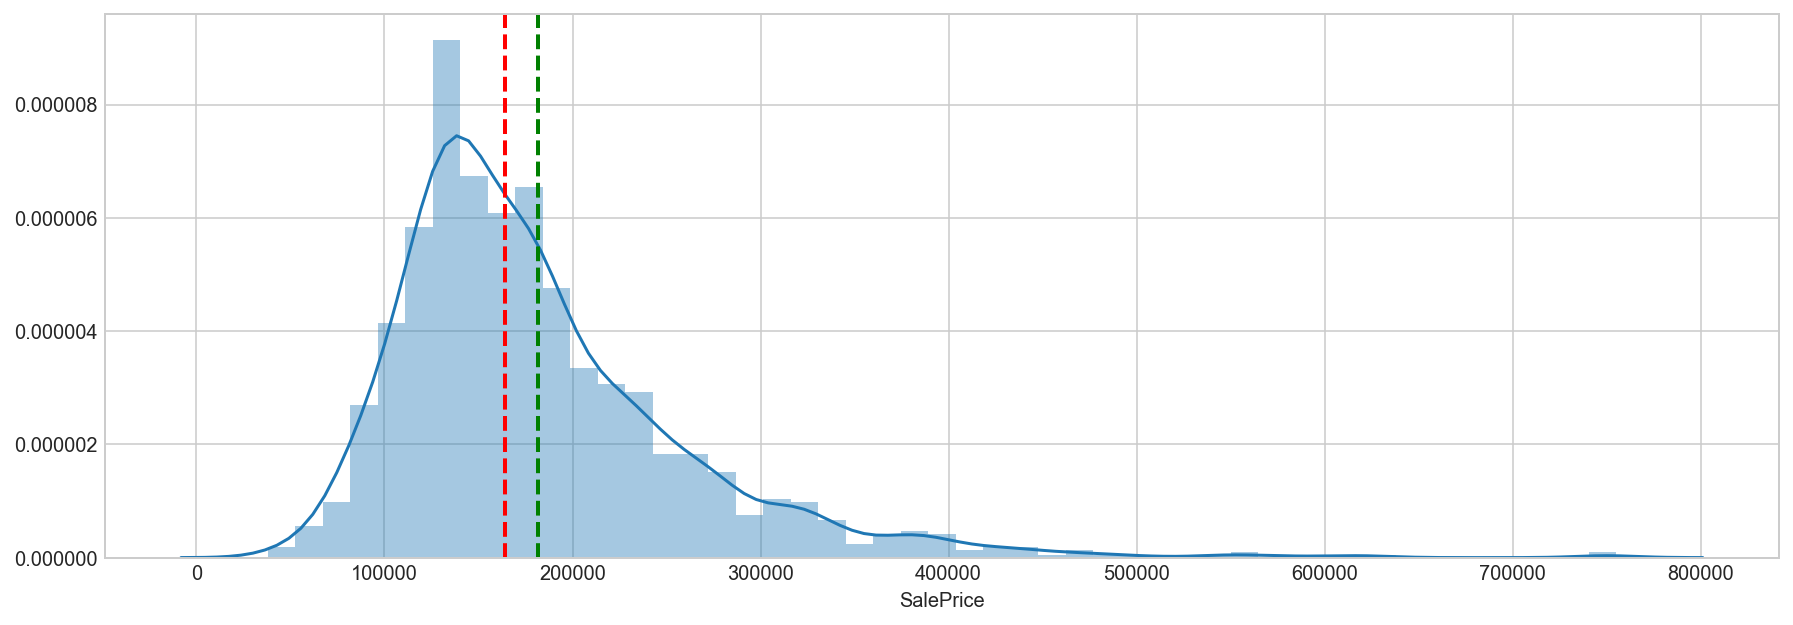

In [641]:
# Lets first take a look at Sale Price Distribution
plt.figure(figsize=(15,5))
sns.distplot(house['SalePrice'])
plt.axvline(house['SalePrice'].mean(), color='g', linestyle='dashed', linewidth=2)
plt.axvline(house['SalePrice'].median(), color='r', linestyle='dashed', linewidth=2)

In [ ]:
# Sale Price is right skewed

# In the context of flipping properties, we will want to purchase at the minimum and sell at the maximum
# Therefore, we will want to ideally purchase properties that are lower than the median,
# and sell properties that are ideally higher than the mean
# The key to achieve this is to characterize our 'purchasable' properties & 'sellable' properties
# Once we have characterization, we can proceed to identify the character gaps between these two classes
# and devise a plan to transform 'purchasable' properties into 'sellable' properties

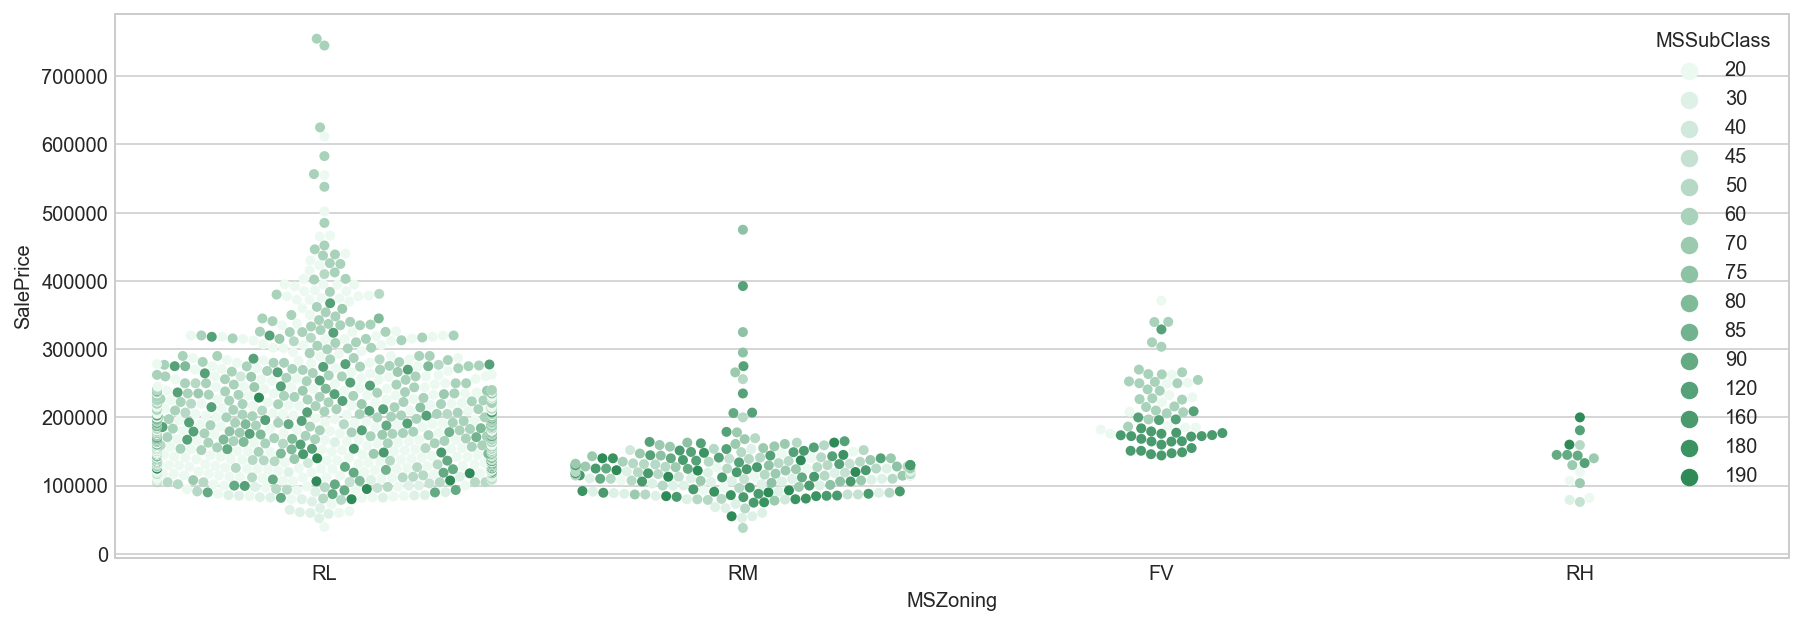

In [633]:
# Observe the Variations of Sales Price and Types of Dwelling among different Zoning Classifications
plt.figure(figsize=(15,5))
palette = sns.light_palette("seagreen", reverse=False,  n_colors=len(house['MSSubClass'].unique()))
sns.swarmplot(x=house['MSZoning'], y=house['SalePrice'], hue=house['MSSubClass'], palette=palette)

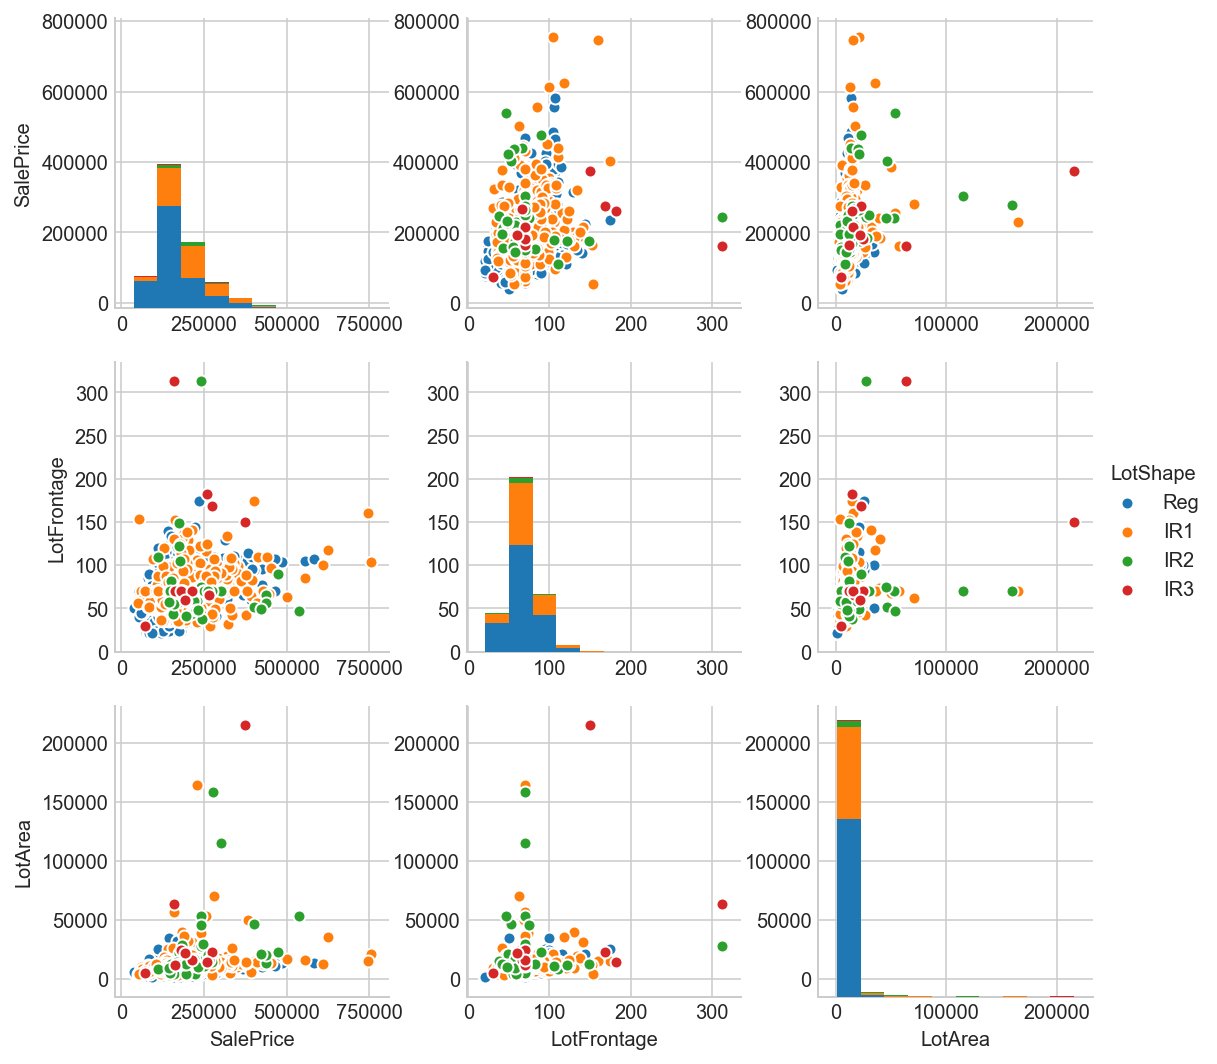

In [637]:
plt.figure(figsize=(15,5))
sns.pairplot(house[['SalePrice','LotFrontage','LotArea','LotShape']], hue='LotShape')

# Fixed Data with Reponse Target

In [580]:
# Get all reno features from house data
reno_features = []

for f in house.columns:
    for reno_f in reno_cols:
        if reno_f in f:
            reno_features.append(f)
            break

In [589]:
# Get reno features from house data with Sale price
reno_house = house[reno_features]

In [582]:
# Remove reno features from house data
fixed_house = house.drop(labels=reno_features, axis=1)
fixed_house.loc[:,'Alley_Grvl':] = fixed_house.loc[:,'Alley_Grvl':].astype('int64')

In [583]:
fixed_house.rename(index=str, 
                   columns={"1stFlrSF": "FirstFlrSF", 
                            "2ndFlrSF": "SecFlrSF",
                           "3SsnPorch": "ThreeSsnPorch"},
                  inplace=True)

In [584]:
# Get X & y
f = 'SalePrice ~ ' + ' + '.join([col for col in fixed_house.columns])
print(f)

y, X = patsy.dmatrices(f, data=fixed_house, return_type='dataframe')

SalePrice ~ MSSubClass + MSZoning + LotFrontage + LotArea + Street + LotShape + LandContour + Utilities + LotConfig + LandSlope + Neighborhood + Condition1 + Condition2 + BldgType + HouseStyle + MasVnrArea + Foundation + BsmtUnfSF + TotalBsmtSF + FirstFlrSF + SecFlrSF + LowQualFinSF + GrLivArea + BsmtFullBath + BsmtHalfBath + FullBath + HalfBath + TotRmsAbvGrd + Fireplaces + GarageArea + PavedDrive + WoodDeckSF + OpenPorchSF + EnclosedPorch + ThreeSsnPorch + ScreenPorch + PoolArea + MiscVal + MoSold + YrSold + SaleType + SaleCondition + SalePrice + Alley_Grvl + Alley_Pave + Built_21stC + RemodAdd_21stC + MasVnrType_BrkCmn + MasVnrType_BrkFace + MasVnrType_Stone + GarageType_2Types + GarageType_Attchd + GarageType_Basment + GarageType_BuiltIn + GarageType_CarPort + GarageType_Detchd + GarageFinish_Fin + GarageFinish_RFn + GarageFinish_Unf + GarageBlt_21stC + MiscFeature_Gar2 + MiscFeature_Othr + MiscFeature_Shed + MiscFeature_TenC


# Feature Selection

 > 
 * Analysis of Variance
 * Pearson Correlation
 * Variance Inflation Factor
 * Recursive Feature Elimination
 * Lasso
 
 

In [586]:
# Use Variance Inflation Factor for detecting multicollinearity
# VIF values > 10 means variance of feature in question can be explained very well by all other features
# This is because the regression of said feature onto all other features has a very high R2, >= 0.9
# Since it is important that we have features that are independent, we should discard features with VIF values > 10
# So dont drop any columns

# Model Selection

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [587]:
# A:

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [588]:
# A: